# Random Forest Classification

## Importing the libraries

In [833]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve, auc, balanced_accuracy_score, roc_auc_score
import pandas as pd
import openml
from openml import tasks
from random_forest import RandomForestClassifier
from SMOTE import smote
from metrics import accuracy, mse, rmse, mae
import torch

<div>
    <h2 style="color: black;">The datasets with class imbalance</h2>
</div>

In [834]:
datasets = [1049, 1497, 1063, 11, 1462, 40982, 1489, 44, 1067, 1475]
for d in datasets:
    dataset=openml.datasets.get_dataset(d)
    data, target, attribute_names, _ = dataset.get_data(target=dataset.default_target_attribute)


    df = pd.concat([data, target], axis=1)
    class_distribution = df[target.name].value_counts(normalize=True)
    print("Dataset:- "+ str(d))
    print(class_distribution)
    print("----------------------------")

Dataset:- 1049
False    0.877915
True     0.122085
Name: c, dtype: float64
----------------------------
Dataset:- 1497
1    0.404142
2    0.384348
4    0.151393
3    0.060117
Name: Class, dtype: float64
----------------------------
Dataset:- 1063
no     0.795019
yes    0.204981
Name: problems, dtype: float64
----------------------------
Dataset:- 11
L    0.4608
R    0.4608
B    0.0784
Name: class, dtype: float64
----------------------------
Dataset:- 1462
1    0.555394
2    0.444606
Name: Class, dtype: float64
----------------------------
Dataset:- 40982
Other_Faults    0.346728
Bumps           0.207110
K_Scratch       0.201443
Z_Scratch       0.097888
Pastry          0.081401
Stains          0.037094
Dirtiness       0.028336
Name: target, dtype: float64
----------------------------
Dataset:- 1489
1    0.706514
2    0.293486
Name: Class, dtype: float64
----------------------------
Dataset:- 44
0    0.605955
1    0.394045
Name: class, dtype: float64
----------------------------
Dataset:

<ipython-input-834-c7d20c06a72e>:3: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  dataset=openml.datasets.get_dataset(d)


In [835]:
def encod_dict(X):
    dic={}
    values=X.unique()
    num=0
    for value in values:
        dic.update({value: num})
        num+=1
    
    return dic

## Importing the dataset

In [836]:
dataset = openml.datasets.get_dataset(1049, download_data=True, download_qualities=True, download_features_meta_data=True)
X,y,_,_=dataset.get_data(target=dataset.default_target_attribute , dataset_format="dataframe")
map_dict=encod_dict(y)
y.replace(map_dict, inplace=True)

## Splitting the dataset into the Training set and Test set

In [837]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [838]:
#print(X_train)
print(f"dataset antes smote {X_train.shape}")
#print(X_train)

dataset antes smote (1093, 37)


In [839]:
print(y_train.shape)
print(y_train)

(1093,)
847     0
809     0
1382    0
1061    0
952     0
       ..
1095    0
1130    0
1294    1
860     0
1126    0
Name: c, Length: 1093, dtype: int64


In [840]:
print(X_test.shape)
#print(X_test)

(365, 37)


In [841]:
print(y_test.shape)
print(y_test)

(365,)
1320    0
836     0
413     0
522     0
1035    0
       ..
679     0
243     0
1036    1
910     1
968     0
Name: c, Length: 365, dtype: int64


## Feature Scaling

In [842]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [843]:
# Apply SMOTE to the training data
X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.long)

In [844]:
print(X_train)

tensor([[ 1.6766, -0.1041,  0.6205,  ...,  0.6961,  0.8030,  0.4787],
        [-0.4984, -0.5747, -0.0995,  ..., -0.5804,  1.0416, -0.6372],
        [ 1.3659, -0.5747,  0.6205,  ...,  0.5496,  2.2842, -0.4226],
        ...,
        [ 0.3301,  0.5233, -0.0995,  ...,  0.6333,  1.5499,  1.2941],
        [-0.7056, -0.5747, -0.8194,  ..., -0.6641, -0.8221, -0.7230],
        [-0.6020, -0.1041, -0.4594,  ..., -0.5176, -0.8221, -0.4655]])


In [845]:
print(X_test)

[[-0.60200148  0.52333333 -0.09946396 ... -0.35018315 -0.56307724
  -0.12215719]
 [ 1.15870834  0.83706065 -0.09946396 ...  0.48684092  0.57564487
   0.47869439]
 [-0.60200148 -0.26098496 -0.45944445 ... -0.58036477 -0.82213186
  -0.59425486]
 ...
 [ 0.43371018  1.62137895  0.26051653 ...  1.36571619  1.16737035
   2.49583899]
 [-0.29128798 -0.41784862 -0.45944445 ... -0.43388556 -0.35620628
  -0.42258298]
 [-0.18771682 -0.41784862 -0.09946396 ... -0.37110875  0.21315477
  -0.50841892]]


<div>
    <h2 style="color: black;">Training the Random Forest Classification model on the Training set with SMOTE</h2>
</div>

In [846]:
smote_i = smote(distance='euclidian', dims=X.shape[1], k=5)# dimns is number of atributes that are not the target

#Classifier modified with smote type binary
classifier_binary = RandomForestClassifier(max_depth=100, smote=smote_i , smote_type="binary")
classifier_binary.fit(X_train, y_train)

print("-----------------------------------")

#Classifier modified with smote type gradient
classifier_gradient = RandomForestClassifier(max_depth=100, smote=smote_i , smote_type="gradient")
classifier_gradient.fit(X_train, y_train)

#Classifier for original model
classifier_original = RandomForestClassifier(max_depth=100)
classifier_original.fit(X_train, y_train)

dataset apos smote:(1093, 37)
dataset apos smote:(1843, 37)
dataset apos smote:(1093, 37)
dataset apos smote:(1843, 37)
dataset apos smote:(1093, 37)
dataset apos smote:(1843, 37)
dataset apos smote:(1093, 37)
dataset apos smote:(1843, 37)
dataset apos smote:(1093, 37)
dataset apos smote:(1843, 37)
-----------------------------------
dataset apos smote:(1093, 37)
dataset apos smote:(1218, 37)
dataset apos smote:(1218, 37)
dataset apos smote:(1343, 37)
dataset apos smote:(1343, 37)
dataset apos smote:(1593, 37)
dataset apos smote:(1593, 37)
dataset apos smote:(1718, 37)
dataset apos smote:(1718, 37)
dataset apos smote:(1843, 37)


## Predicting a new result

In [847]:
#Prediction for modified model with binary smote
predictions=classifier_binary._predict(X_test)
#print(predictions)

#print("-----------------------------------")

#Prediction for modified model with gradient smote
predictions=classifier_gradient._predict(X_test)
#print(predictions)

#print("-----------------------------------")

#Predictions for original model
predictions_original=classifier_original._predict(X_test)
#print(predictions_original)

## Predicting the Test set results

In [848]:
# Predicting the Test set result for model with binary smote
y_pred_proba_binary = classifier_binary._predict(X_test)  # Get the prediction probabilities
y_pred_binary = np.argmax(y_pred_proba_binary, axis=1)    # Get the class with the highest probability
# Print predictions vs actual
#print("Predicted and test values from modified model")
#print(np.concatenate((y_pred.reshape(len(y_pred), 1), y_test.values.reshape(len(y_test), 1)), 1))

#print("---------------------------------")

# Predicting the Test set result for model with gradient smote
y_pred_proba_gradient = classifier_gradient._predict(X_test)  # Get the prediction probabilities
y_pred_gradient = np.argmax(y_pred_proba_gradient, axis=1)    # Get the class with the highest probability
# Print predictions vs actual
#print("Predicted and test values from modified model")
#print(np.concatenate((y_pred.reshape(len(y_pred), 1), y_test.values.reshape(len(y_test), 1)), 1))

#print("---------------------------------")

y_pred_proba_original = classifier_original._predict(X_test)
y_pred_original = np.argmax(y_pred_proba_original, axis=1)    
# Print predictions vs actual
#print("Predicted and test values from original model")
#print(np.concatenate((y_pred_original.reshape(len(y_pred_original), 1), y_test.values.reshape(len(y_test), 1)), 1))

## Making the Confusion Matrix

Confusion matrix from modified model with binary smote
Overall Accuracy: 0.90


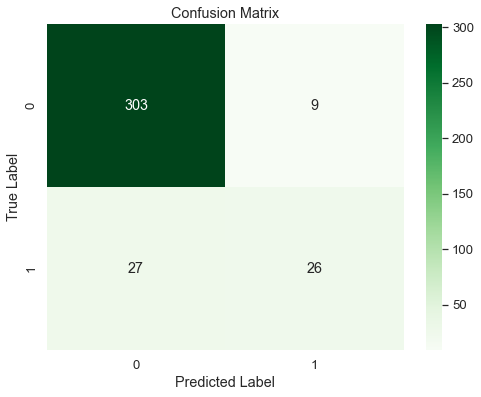

------------------------------------
Confusion matrix from modified model with gradient smote
Overall Accuracy: 0.90


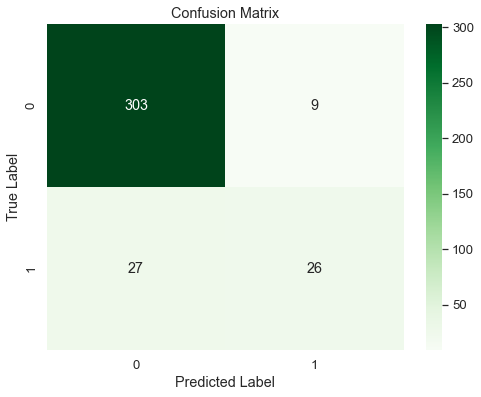

------------------------------------
Confusion matrix from original model
Overall Accuracy: 0.90


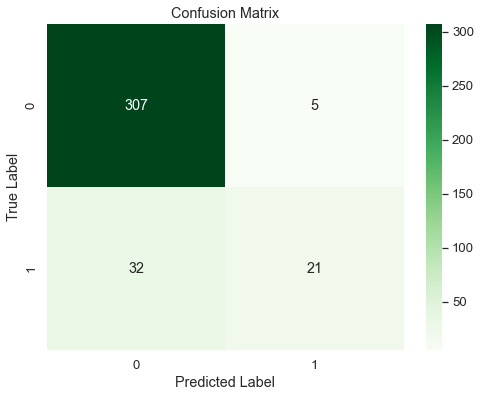

In [849]:
def plot_confusion_matrix(y_test, y_pred, class_names):
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=class_names)
           
    # Calculate overall accuracy
    accuracy = np.trace(cm) / np.sum(cm)    
    # Display overall accuracy
    print(f"Overall Accuracy: {accuracy:.2f}")

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, fmt='d', cmap="Greens", 
                xticklabels=class_names, 
                yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
    return accuracy
    
class_names = np.unique(y_train)
print("Confusion matrix from modified model with binary smote")
cm_accuracy_binary = plot_confusion_matrix(y_test, y_pred_binary, class_names)
print("------------------------------------")
print("Confusion matrix from modified model with gradient smote")
cm_accuracy_gradient = plot_confusion_matrix(y_test, y_pred_gradient, class_names)
print("------------------------------------")
print("Confusion matrix from original model")
cm_accuracy_original = plot_confusion_matrix(y_test, y_pred_original, class_names)

<div>
    <h2 style="color: black;">Making ROC_AUC_CURVE</h2>
</div>

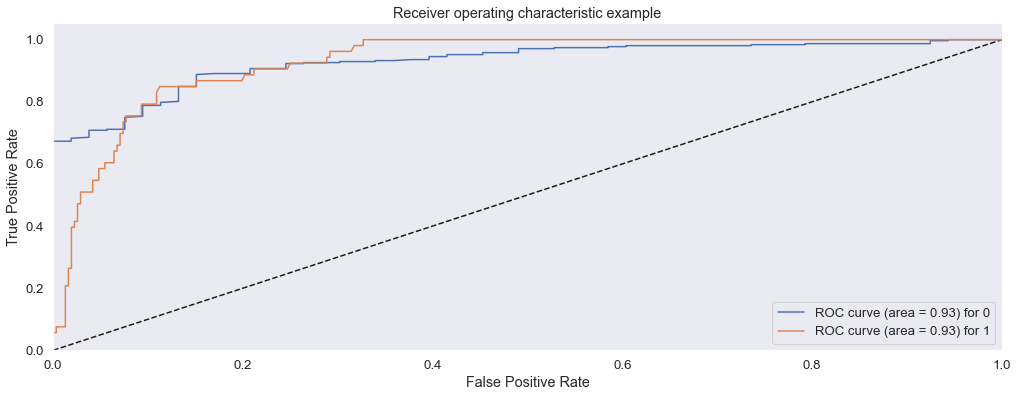

Average ROC_AUC_SCORE from modified model with binary smote:  0.93
------------------------------------


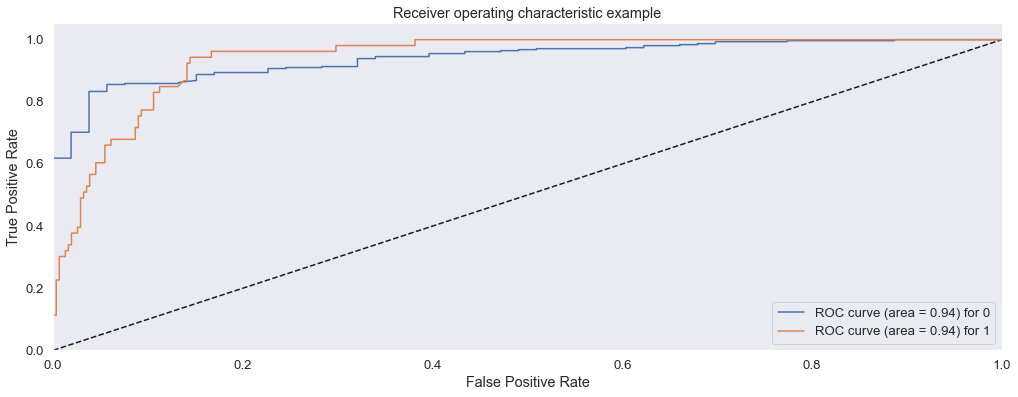

ROC_AUC_CURVE from modified model with gradient smote:  0.94
------------------------------------


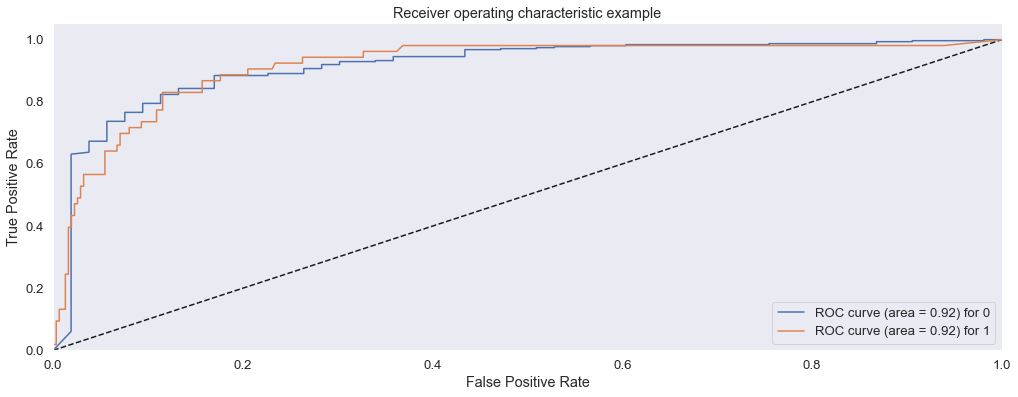

ROC_AUC_CURVE from original model:  0.92


In [850]:
def plot_multiclass_roc(clf, X_test, y_test, class_names, figsize=(17, 6)):
    y_pred = clf._predict(X_test)
    
    # Check for NaN values and replace them with 0
    if np.any(np.isnan(y_pred)):
        y_pred = np.nan_to_num(y_pred)
    
    # Clip the predicted probabilities to be within the range [0, 1]
    y_pred = np.clip(y_pred, 0, 1)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = len(class_names)
    total_auc_score = 0

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for {class_names[i]}')
        total_auc_score += roc_auc[i]
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()
    return round(total_auc_score / n_classes, 2)

class_names = np.unique(y_train)
avg_auc_binary = plot_multiclass_roc(classifier_binary, X_test, y_test, class_names)
print("Average ROC_AUC_SCORE from modified model with binary smote: ", avg_auc_binary)
print("------------------------------------")
avg_auc_gradient = plot_multiclass_roc(classifier_gradient, X_test, y_test, class_names)
print("ROC_AUC_CURVE from modified model with gradient smote: ", avg_auc_gradient)
print("------------------------------------")
avg_auc_original = plot_multiclass_roc(classifier_original, X_test, y_test, class_names)
print("ROC_AUC_CURVE from original model: ", avg_auc_original)

<div>
    <h2 style="color: black;">Making Balanced Accuracy Score</h2>
</div>

Balanced Accuracy Score from modified model with binary smote: 
Balanced Accuracy Score: 0.73


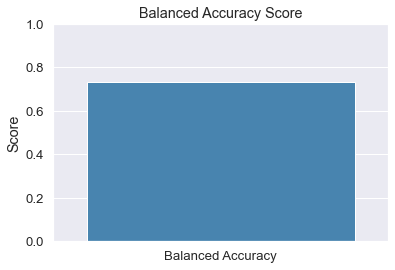

------------------------------------
Balanced Accuracy Score from modified model with gradient smote
Balanced Accuracy Score: 0.73


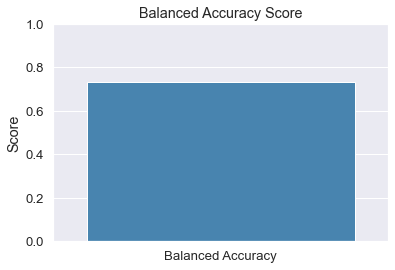

------------------------------------
Balanced Accuracy Score from original model
Balanced Accuracy Score: 0.69


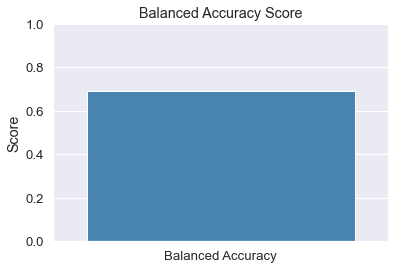

In [851]:
def plot_balanced_accuracy(y_test, y_pred):
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    print(f"Balanced Accuracy Score: {bal_acc:.2f}")

    plt.figure(figsize=(6, 4))
    sns.set(font_scale=1.2) 
    sns.barplot(x=['Balanced Accuracy'], y=[bal_acc], palette='Blues_d')
    plt.ylim(0, 1)
    plt.ylabel('Score')
    plt.title('Balanced Accuracy Score')
    plt.show()
    return bal_acc
print("Balanced Accuracy Score from modified model with binary smote: ")
balanced_accuracy_binary = plot_balanced_accuracy(y_test, y_pred_binary)
print("------------------------------------")
print("Balanced Accuracy Score from modified model with gradient smote")
balanced_accuracy_gradient = plot_balanced_accuracy(y_test, y_pred_gradient)
print("------------------------------------")
print("Balanced Accuracy Score from original model")
balanced_accuracy_original = plot_balanced_accuracy(y_test, y_pred_original)

<div>
    <h2 style="color: black;">Different metrics to compare original and modified models</h2>
</div>

In [852]:
def calculate_errors(mse, rmse, mae):
    return {
        "Mean Squared Error": mse,
        "Root Mean Squared Error": rmse,
        "Mean Absolute Error": mae
    }

mse_binary = mse(y_test, y_pred_binary)
rmse_binary = rmse(y_test, y_pred_binary)
mae_binary = mae(y_test, y_pred_binary)
print("For Modified model with binary smote\n", calculate_errors(mse_binary, rmse_binary, mae_binary))
print("-----------------")
mse_gradient = mse(y_test, y_pred_gradient)
rmse_gradient = rmse(y_test, y_pred_gradient)
mae_gradient = mae(y_test, y_pred_gradient)
print("For Modified model with gradient smote\n", calculate_errors(mse_gradient, rmse_gradient, mae_gradient))
print("-----------------")
mse_original = mse(y_test, y_pred_original)
rmse_original = rmse(y_test, y_pred_original)
mae_original = mae(y_test, y_pred_original)
print("For Original model\n", calculate_errors(mse_original, rmse_original, mae_original))

For Modified model with binary smote
 {'Mean Squared Error': 0.09863013698630137, 'Root Mean Squared Error': 0.3140543535541282, 'Mean Absolute Error': 0.09863013698630137}
-----------------
For Modified model with gradient smote
 {'Mean Squared Error': 0.09863013698630137, 'Root Mean Squared Error': 0.3140543535541282, 'Mean Absolute Error': 0.09863013698630137}
-----------------
For Original model
 {'Mean Squared Error': 0.10136986301369863, 'Root Mean Squared Error': 0.31838634237934677, 'Mean Absolute Error': 0.10136986301369863}


<div>
    <h2 style="color: black;">Finding the overall scores and errors of different models</h2>
</div>

In [853]:
def find_average(*args):
    total = sum(args)
    count = len(args)
    average = total / count
    return average

In [854]:
#Average of mse, rmse and mae errors
print("Overall error of model with binary smote: ", find_average(mse_binary, rmse_binary, mae_binary))
print("Overall error of model with gradient smote: ", find_average(mse_gradient, rmse_gradient, mae_gradient))
print("Overall error of original model: ", find_average(mse_original, rmse_original, mae_original))

Overall error of model with binary smote:  0.17043820917557698
Overall error of model with gradient smote:  0.17043820917557698
Overall error of original model:  0.17370868946891468
